##### Emily Ahn 69064335
##### Yimeng Liu 23833957

# Stock Data Visualization and Stock Market Forecasting

## Introduction

As important as stock predictions can be, it is known to be a complicated and daunting task. In this project we aim to use machine learning, specifically time forecasting using ARIMA to predict stock prices. 

In this project we want to predict top 3 NASDAQ companies, namely Amazon, Apple, and Microsoft as these 3 take up 30% of the NASDAQ weight. As these companies are significant in NASDAQ and the economy in general we felt that it was fitting to choose these three . 

The ARIMA model uses p (autoregressive order), d (differencing order), and q (moving average order) to predict aid the temporal dependencies. We will use Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plot to determine the best p, d, and q for the corresponding training data. By using ARIMA we hope to make a model that accurately predicts the stock prices of Amazon, Apple, and Microsoft and gives insight into the trends and pattern of the stock market. 

### Required packages

In [ ]:
!pip install pmdarima

In [273]:
import pandas as pd
import numpy as np
import altair as alt
import math
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf as acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
# from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error

### Loading required dataset

In [274]:
# Amazon
amzn = pd.read_csv('data/AMZN.csv')
# Apple
aapl = pd.read_csv('data/AAPL.csv')
# Microsft
msft = pd.read_csv('data/MSFT.csv')

In [275]:
# load data after last 10 years from 2012, 2022
amzn1 = pd.read_csv('data/AMZN.csv',index_col=0,parse_dates=[0]).iloc[3684:]
aapl1 = pd.read_csv('data/AAPL.csv',index_col=0,parse_dates=[0]).iloc[7836:]
msft1 = pd.read_csv('data/MSFT.csv',index_col=0,parse_dates=[0]).iloc[6510:]


/tmp/ipykernel_284/1481221538.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amzn1 = pd.read_csv('data/AMZN.csv',index_col=0,parse_dates=[0]).iloc[3684:]
/tmp/ipykernel_284/1481221538.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  aapl1 = pd.read_csv('data/AAPL.csv',index_col=0,parse_dates=[0]).iloc[7836:]
/tmp/ipykernel_284/1481221538.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  msft1 = pd.read_csv('data/MSFT.csv',index_col=0,parse_dates=[0]).iloc[6510:]


## Exploratory Data Analysis

In [276]:
amzn.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,15-05-1997,0.096354,0.121875,1443120000,0.125000,0.097917,0.097917
1,16-05-1997,0.085417,0.098438,294000000,0.098958,0.086458,0.086458
2,19-05-1997,0.081250,0.088021,122136000,0.088542,0.085417,0.085417
3,20-05-1997,0.081771,0.086458,109344000,0.087500,0.081771,0.081771
4,21-05-1997,0.068750,0.081771,377064000,0.082292,0.071354,0.071354


In [277]:
aapl.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,12-12-1980,0.128348,0.128348,469033600,0.128906,0.128348,0.099874
1,15-12-1980,0.121652,0.122210,175884800,0.122210,0.121652,0.094663
2,16-12-1980,0.112723,0.113281,105728000,0.113281,0.112723,0.087715
3,17-12-1980,0.115513,0.115513,86441600,0.116071,0.115513,0.089886
4,18-12-1980,0.118862,0.118862,73449600,0.119420,0.118862,0.092492


In [278]:
msft.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,13-03-1986,0.088542,0.088542,1031788800,0.101563,0.097222,0.061608
1,14-03-1986,0.097222,0.097222,308160000,0.102431,0.100694,0.063809
2,17-03-1986,0.100694,0.100694,133171200,0.103299,0.102431,0.064909
3,18-03-1986,0.098958,0.102431,67766400,0.103299,0.099826,0.063258
4,19-03-1986,0.097222,0.099826,47894400,0.100694,0.098090,0.062158


In [279]:
# amazon average monthly open value list
amazon_monthly_open = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Open'].mean().reset_index()

amazon_monthly_open['Date'] = amazon_monthly_open['Date'].apply(lambda x: x.to_timestamp())

# apple average monthly open value list
apple_monthly_open = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Open'].mean().reset_index()

apple_monthly_open['Date'] = apple_monthly_open['Date'].apply(lambda x: x.to_timestamp())

# microsoft average monthly open value list
microsoft_monthly_open = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Open'].mean().reset_index()

microsoft_monthly_open['Date'] = microsoft_monthly_open['Date'].apply(lambda x: x.to_timestamp())

# create company comlumn that shows where the data is from
amazon_monthly_open['company']= 'amzn'
apple_monthly_open['company']= 'aapl'
microsoft_monthly_open['company']= 'msft'

opens = [amazon_monthly_open, apple_monthly_open, microsoft_monthly_open]

# concat all companes into one df
open_top3_nasdaq = pd.concat(opens)

open_top3_nasdaq.head()

/tmp/ipykernel_284/2226228315.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amazon_monthly_open = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Open'].mean().reset_index()
/tmp/ipykernel_284/2226228315.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  apple_monthly_open = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Open'].mean().reset_index()
/tmp/ipykernel_284/2226228315.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  microsoft_monthly_open = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Open'].mean().reset_index()


,Date,Open,company
0,1997-01-01,0.157031,amzn
1,1997-02-01,0.136719,amzn
2,1997-03-01,0.158117,amzn
3,1997-04-01,0.156198,amzn
4,1997-05-01,0.107194,amzn


#### Looking at dataframe info

In [280]:
for c in [amzn, aapl, msft]:
    print(c.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6438 entries, 0 to 6437
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            6438 non-null   object 
 1   Low             6438 non-null   float64
 2   Open            6438 non-null   float64
 3   Volume          6438 non-null   int64  
 4   High            6438 non-null   float64
 5   Close           6438 non-null   float64
 6   Adjusted Close  6438 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 352.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10590 entries, 0 to 10589
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            10590 non-null  object 
 1   Low             10590 non-null  float64
 2   Open            10590 non-null  float64
 3   Volume          10590 non-null  int64  
 4   High            10590 non-null  float

#### Checking for null value

In [281]:
for c in [amzn, aapl, msft]:
    print(c.isnull().sum())

Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64
Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64
Date              0
Low               0
Open              0
Volume            0
High              0
Close             0
Adjusted Close    0
dtype: int64


In [282]:
# amazon average monthly closing value list
amazon_monthly_close = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Close'].mean().reset_index()

amazon_monthly_close['Date'] = amazon_monthly_close['Date'].apply(lambda x: x.to_timestamp())

# apple average monthly closing value list
apple_monthly_close = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Close'].mean().reset_index()

apple_monthly_close['Date'] = apple_monthly_close['Date'].apply(lambda x: x.to_timestamp())

# microsoft average monthly closing value list
microsoft_monthly_close = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Close'].mean().reset_index()

microsoft_monthly_close['Date'] = microsoft_monthly_close['Date'].apply(lambda x: x.to_timestamp())

# create company comlumn that shows where the data is from
amazon_monthly_close['company']= 'amzn'
apple_monthly_close['company']= 'aapl'
microsoft_monthly_close['company']= 'msft'

closings = [amazon_monthly_close, apple_monthly_close, microsoft_monthly_close]

# concat all companes into one df
close_top3_nasdaq = pd.concat(closings)

close_top3_nasdaq.head()

/tmp/ipykernel_284/954031980.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amazon_monthly_close = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Close'].mean().reset_index()
/tmp/ipykernel_284/954031980.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  apple_monthly_close = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Close'].mean().reset_index()
/tmp/ipykernel_284/954031980.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  microsoft_monthly_close = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Close'].mean().reset_index(

,Date,Close,company
0,1997-01-01,0.152800,amzn
1,1997-02-01,0.136979,amzn
2,1997-03-01,0.159809,amzn
3,1997-04-01,0.157396,amzn
4,1997-05-01,0.103727,amzn


In [283]:
# amazon average monthly volumn
amazon_monthly_volume = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Volume'].mean().reset_index()

amazon_monthly_volume['Date'] = amazon_monthly_volume['Date'].apply(lambda x: x.to_timestamp())

# apple average monthly volumn
apple_monthly_volume = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Volume'].mean().reset_index()

apple_monthly_volume['Date'] = apple_monthly_volume['Date'].apply(lambda x: x.to_timestamp())

# microsoft average monthly volumn
microsoft_monthly_volume = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Volume'].mean().reset_index()

microsoft_monthly_volume['Date'] = microsoft_monthly_volume['Date'].apply(lambda x: x.to_timestamp())

# create company comlumn that shows where the data is from
amazon_monthly_volume['company']= 'amzn'
apple_monthly_volume['company']= 'aapl'
microsoft_monthly_volume['company']= 'msft'

volume = [amazon_monthly_volume, apple_monthly_volume, microsoft_monthly_volume]

# concat all companes into one df
volume_top3_nasdaq = pd.concat(volume)

volume_top3_nasdaq.head()

/tmp/ipykernel_284/681992908.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  amazon_monthly_volume = amzn.groupby(pd.PeriodIndex(amzn['Date'], freq="M"))['Volume'].mean().reset_index()
/tmp/ipykernel_284/681992908.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  apple_monthly_volume = aapl.groupby(pd.PeriodIndex(aapl['Date'], freq="M"))['Volume'].mean().reset_index()
/tmp/ipykernel_284/681992908.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  microsoft_monthly_volume = msft.groupby(pd.PeriodIndex(msft['Date'], freq="M"))['Volume'].mean().reset_

,Date,Volume,company
0,1997-01-01,61314000.0,amzn
1,1997-02-01,33379200.0,amzn
2,1997-03-01,67260000.0,amzn
3,1997-04-01,58012800.0,amzn
4,1997-05-01,225880500.0,amzn


### Plots

### Opening prices by companies

In [324]:
# selection interaction
nearest = alt.selection_single(nearest=True, on='mouseover')

# stock average monthly open value 
monthly_open_plt = alt.Chart(open_top3_nasdaq).mark_line(interpolate='basis').encode(
    alt.X('Date:T'),
    alt.Y('Open:Q', type='quantitative'),
    color='company:N'
)

# select chart
selectors = alt.Chart(open_top3_nasdaq).mark_point().encode(
    alt.X('Date:T'),
    opacity=alt.value(0),
).add_selection (
    nearest
)

# Draw points on the line, and highlight based on selection
points = monthly_open_plt.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = monthly_open_plt.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Open:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(open_top3_nasdaq).mark_rule(color='gray').encode(
    alt.X('Date:T'),
).transform_filter(
    nearest
)
                         
# 

# Put the five layers into a chart and bind the data
open_plot = alt.layer(
    monthly_open_plt, selectors, points, rules, text,
    title = 'Opening value by companies'
).properties(
    width=600
).interactive(
)

### Closing prices by companies

In [325]:
# selection interaction
nearest = alt.selection_single(nearest=True, on='mouseover')

# stock average monthly open value 
monthly_close_plt = alt.Chart(close_top3_nasdaq).mark_line(interpolate='basis').encode(
    alt.X('Date:T'),
    alt.Y('Close:Q', type='quantitative'),
    color='company:N'
)

# select chart
selectors = alt.Chart(close_top3_nasdaq).mark_point().encode(
    alt.X('Date:T'),
    opacity=alt.value(0),
).add_selection (
    nearest
)

# Draw points on the line, and highlight based on selection
points = monthly_close_plt.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = monthly_close_plt.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Close:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(close_top3_nasdaq).mark_rule(color='gray').encode(
    alt.X('Date:T'),
).transform_filter(
    nearest
)
                         
# 

# Put the five layers into a chart and bind the data
close_plot = alt.layer(
    monthly_close_plt, selectors, points, rules, text,
    title = 'Closing value by companies'
).properties(
    width=600
).interactive(
)

### Volumn prices by companies

In [326]:
# selection interaction
nearest = alt.selection_single(nearest=True, on='mouseover')

# stock average monthly open value 
monthly_volume_plt = alt.Chart(volume_top3_nasdaq).mark_line(interpolate='basis').encode(
    alt.X('Date:T'),
    alt.Y('Volume:Q', type='quantitative'),
    color='company:N'
)

# select chart
selectors = alt.Chart(volume_top3_nasdaq).mark_point().encode(
    alt.X('Date:T'),
    opacity=alt.value(0),
).add_selection (
    nearest
)

# point 
points = monthly_volume_plt.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# text
text = monthly_volume_plt.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'Volume:Q', alt.value(' '))
)

# ruling
rules = alt.Chart(volume_top3_nasdaq).mark_rule(color='gray').encode(
    alt.X('Date:T'),
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
volume_plot = alt.layer(
    monthly_volume_plt, selectors, points, rules, text,
    title = 'Volume by companies'
).properties(
    width=600
).interactive(
)

In [327]:
alt.vconcat(open_plot,close_plot,volume_plot)

alt.VConcatChart(...)

Above plots each show open, close, volume value of each stock. You can zoom in and out of the plot and hover over the lines to see the specific value at the specific time. We can notice that for open and close value all three companiese have a pretty similar projection that almost consistently goes up and falls around 2021. Volume for all stocks stay fairly consistent except for apple where it's volume spiked around 2008.

Correlation graph

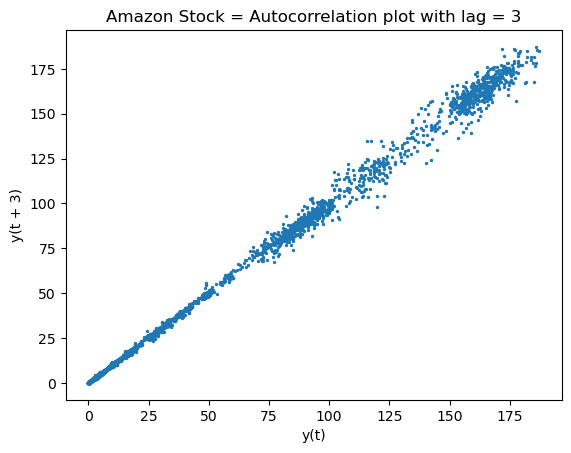

In [288]:
plt.figure()
lag_plot(amzn['Open'], lag=3, s = 2)
plt.title('Amazon Stock = Autocorrelation plot with lag = 3')
plt.show()

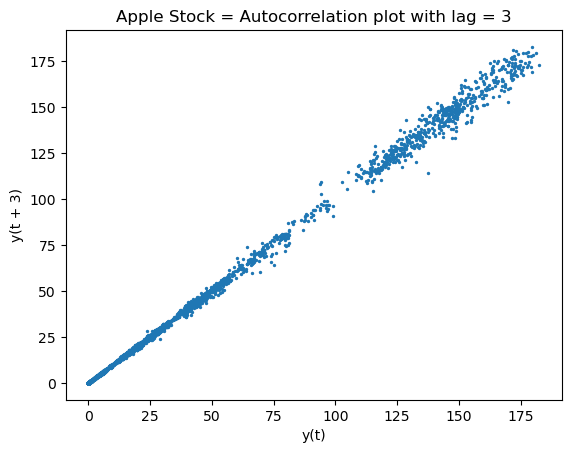

In [289]:
plt.figure()
lag_plot(aapl['Open'], lag=3, s = 2)
plt.title('Apple Stock = Autocorrelation plot with lag = 3')
plt.show()

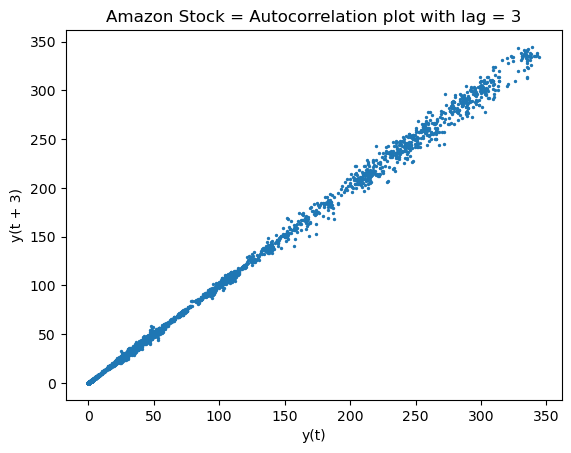

In [290]:
plt.figure()
lag_plot(msft['Open'], lag=3, s = 2)
plt.title('Amazon Stock = Autocorrelation plot with lag = 3')
plt.show()

##### Seeing the above lag plots show that there  is a linear pattern and ARIMA will be a suited model

## ARIMA Model Construction
### Method
ARIMA stands for Auto Regressive Integrated Moving Average. It is a statistical analysis model that uses time series data to either better understand the dataset or to predict future trends. An autoregressive statistical model predicts future values based on past values. The ARIMA model is considered as a efficient, reliable technique and has been widely utilized in many fields, such as banking and economics. In our project, we are going to using ARIMA model to seek to predict a stock's future prices based on its past performance.

To construct an ARIMA model, all we need is to find three parameters, p, d, q.

### Prepare data
In our project, we decided to focus on the Closing price of each stock and make predictions of it using Time Series with ARIMA model. To get prepared for it, we first need to construct training data and testing data. We started by converting daily data into the mean of weekly data, which reduced the amount of data to make the process more efficient. Then, we divided the data into training data, which is from 2012 to 2021, and the rest to be testing data. The ratio of training data and testing data is about 8:2. Moreover, as there are great fluctuations in stock market prices, to reduce the magnitude of the values and the growing trend in the series, we took a log of the series.

In [291]:
amzn_week = amzn1['Close'].resample('W-MON').mean()
aapl_week = aapl1['Close'].resample('W-MON').mean()
msft_week = msft1['Close'].resample('W-MON').mean()

amzn_train=np.log(amzn_week['2012':'2021'])
amzn_test=np.log(amzn_week['2021':])

aapl_train=np.log(aapl_week['2012':'2021'])
aapl_test=np.log(aapl_week['2021':])

msft_train=np.log(msft_week['2012':'2021'])
msft_test=np.log(msft_week['2021':])

The plots below show the training data and testing data of all three companies.

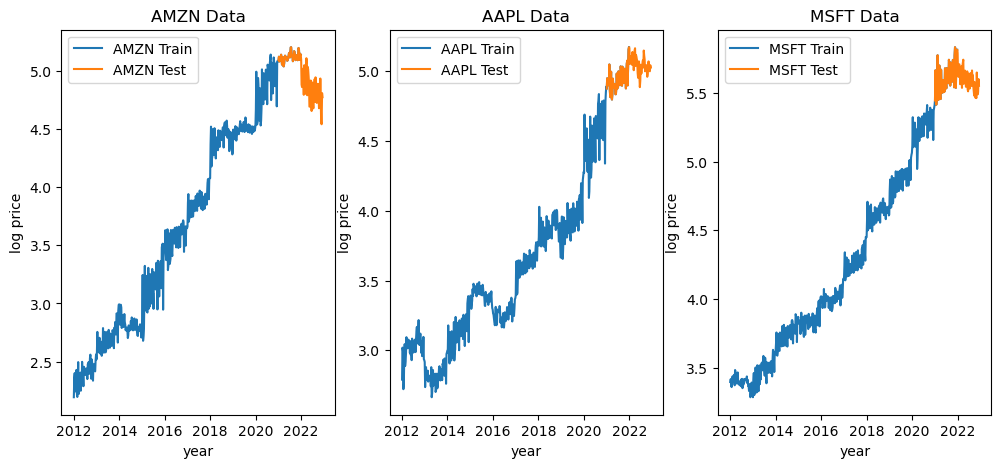

In [292]:
fig, ax = plt.subplots(1,3,figsize=(12,5))
ax[0].plot(amzn_train, label='AMZN Train')
ax[0].plot(amzn_test, label='AMZN Test')
ax[0].set_title('AMZN Data')
ax[1].plot(aapl_train, label='AAPL Train')
ax[1].plot(aapl_test, label='AAPL Test')
ax[1].set_title('AAPL Data')
ax[2].plot(msft_train, label='MSFT Train')
ax[2].plot(msft_test, label='MSFT Test')
ax[2].set_title('MSFT Data')
for i in range (0,3):
    ax[i].set_xlabel('year')
    ax[i].set_ylabel('log price')
    ax[i].legend()
plt.show()

### ARIMA Model for Amazon 
#### Stationary Check (Choosing d)
##### Stationary Definition
*
##### ADF (Augmented Dickey-Fuller) Test
*

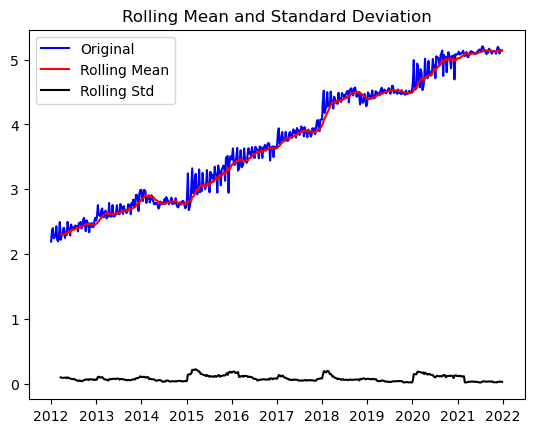

P-value:  0.8817621118733818


In [293]:
def stationarity_check(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
def ad_test(dataset):
    dftest=adfuller(dataset, autolag = 'AIC')
    print("P-value: ", dftest[1])
    
stationarity_check(amzn_train)
ad_test(amzn_train)

The rolling mean (red) and the raw stock value (blue) increases overtime while the standard deviation stays relatively static.

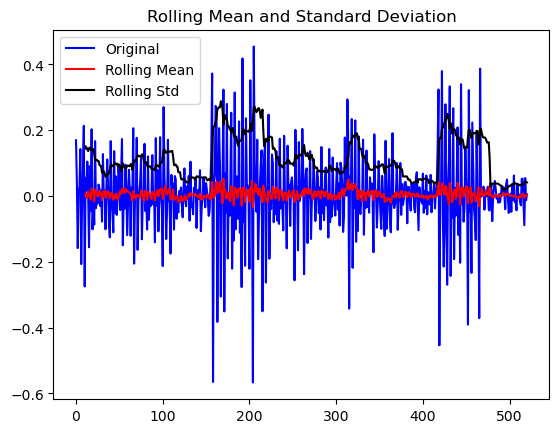

P-value:  1.2240337451039778e-07


In [294]:
amzn_diff = np.diff(amzn_train)
amzn_diff = pd.DataFrame(amzn_diff)
stationarity_check(amzn_diff)
ad_test(amzn_diff)

**Explain above, choose d

#### ACF and PACF (Choosing p and q)
##### What is ACF
##### What is PACF
##### How to choose p and q

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


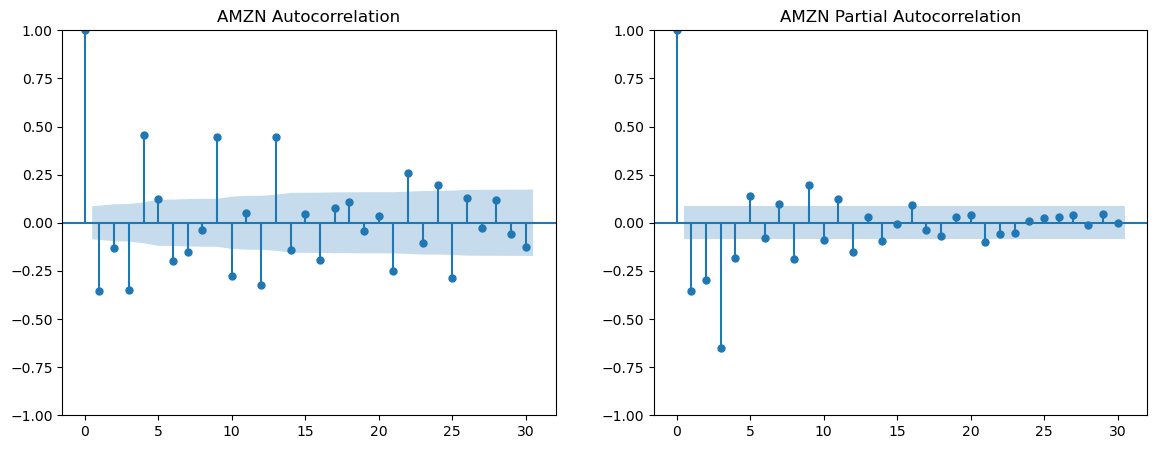

In [295]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
amzn_acf = plot_acf(amzn_diff, lags=30, ax=ax[0],alpha=.05)
amzn_pacf = plot_pacf(amzn_diff, lags=30, ax=ax[1],alpha=.05)
ax[0].set_title('AMZN Autocorrelation')
ax[1].set_title('AMZN Partial Autocorrelation')
plt.show()

** Choose p q for amzn

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-689.332, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-757.374, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-916.144, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-690.257, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-915.386, Time=1.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-916.433, Time=1.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-915.635, Time=2.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-944.122, Time=2.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-945.625, Time=2.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1048.323, Time=3.80 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-995.036, Time=2.11 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1102.174, Time=3.88 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1101.840, Time=3.30 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-1084.993, Time=1.81 sec

Best model:  ARIMA(3,1,3)(0,

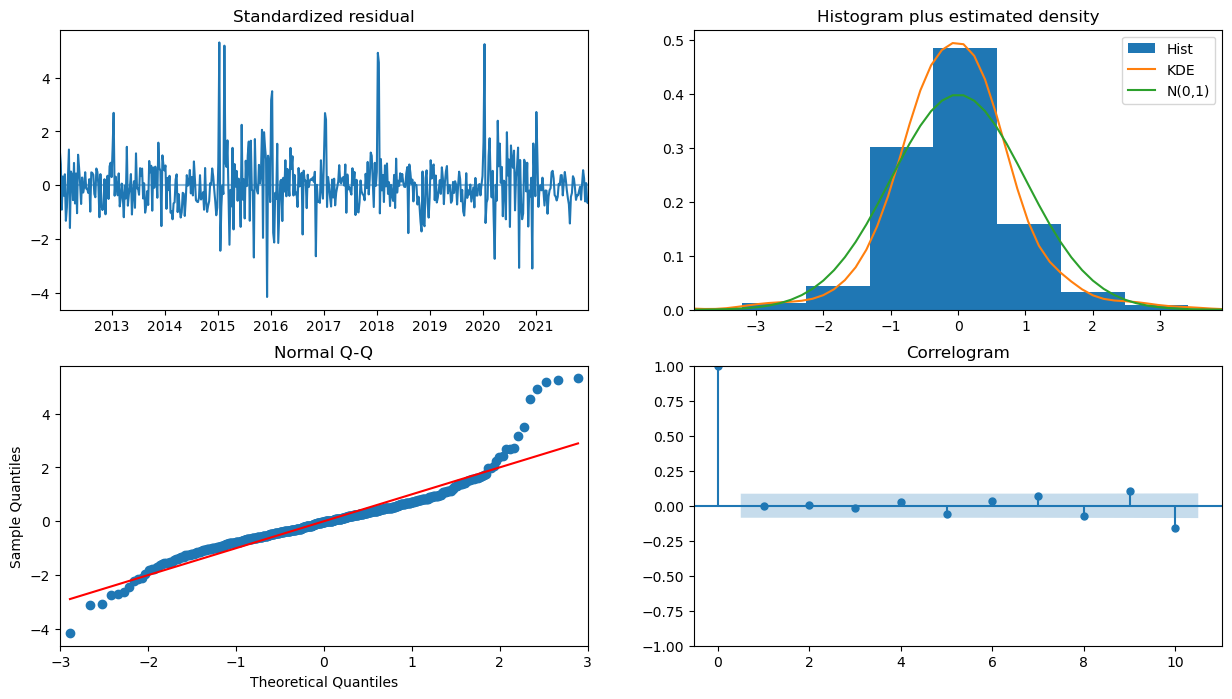

In [296]:
model_autoARIMA = auto_arima(amzn_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [297]:
amzn_model = ARIMA(amzn_train, order=(3,1,3),freq='W-MON')
amzn_fitted = amzn_model.fit()  
print(amzn_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  522
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 549.496
Date:                Mon, 24 Apr 2023   AIC                          -1084.993
Time:                        22:02:40   BIC                          -1055.203
Sample:                    01-02-2012   HQIC                         -1073.324
                         - 12-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4640      0.045    -10.216      0.000      -0.553      -0.375
ar.L2         -0.6500      0.046    -14.163      0.000      -0.740      -0.560
ar.L3         -0.6210      0.041    -14.991      0.0

** forcasting

In [306]:
history = [x for x in amzn_train]
model_predictions = []
N_test_observations = len(amzn_test)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(3,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = amzn_test[time_point]
    history.append(true_test_value)

In [307]:
amzn_MSE_error = mean_squared_error(amzn_test, model_predictions)
print('Testing Mean Squared Error for Amazon is {}'.format(amzn_MSE_error))

Testing Mean Squared Error for Amazon is 0.006303701469623125


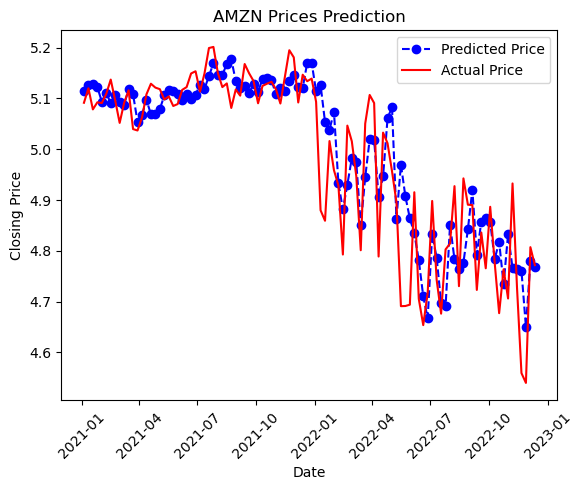

In [309]:
test_set_range= amzn_test.index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, amzn_test, color='red', label='Actual Price')
plt.title('AMZN Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

### ARIMA Model for Apple

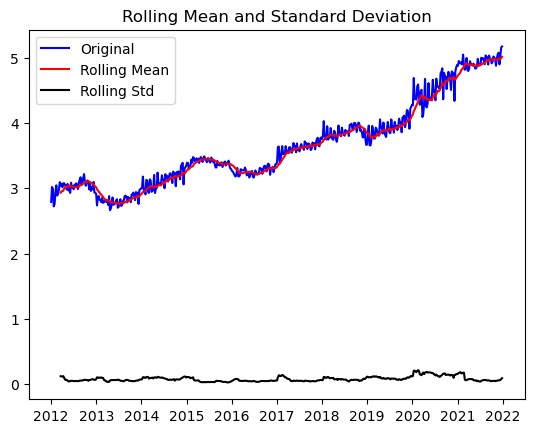

P-value:  0.9970028334171789


In [310]:
stationarity_check(aapl_train)
ad_test(aapl_train)

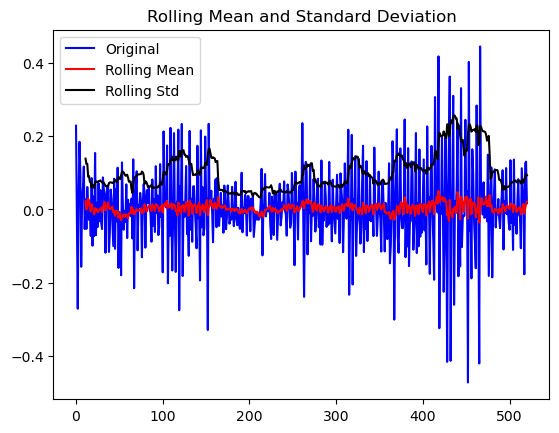

P-value:  3.024559647582668e-06


In [311]:
aapl_diff = np.diff(aapl_train)
aapl_diff = pd.DataFrame(aapl_diff)
stationarity_check(aapl_diff)
ad_test(aapl_diff)

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


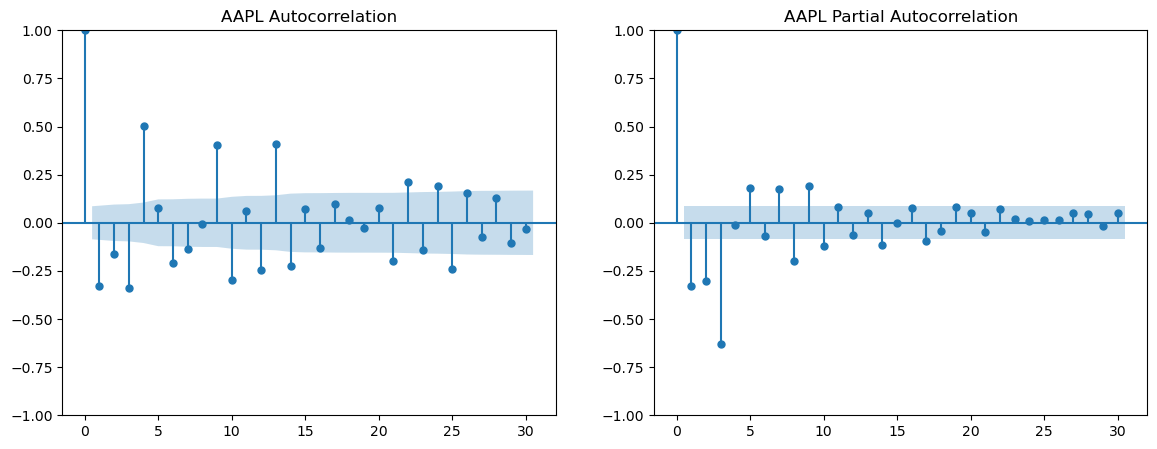

In [312]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
aapl_acf = plot_acf(aapl_diff, lags=30, ax=ax[0],alpha=.05)
aapl_pacf = plot_pacf(aapl_diff, lags=30, ax=ax[1],alpha=.05)
ax[0].set_title('AAPL Autocorrelation')
ax[1].set_title('AAPL Partial Autocorrelation')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-816.546, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-874.012, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-997.285, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-817.649, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-845.640, Time=1.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1000.174, Time=0.99 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-999.220, Time=1.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1023.858, Time=3.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1033.559, Time=2.61 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1107.763, Time=4.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1086.962, Time=1.90 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1196.542, Time=3.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1198.542, Time=2.59 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1187.300, Time=2.22 sec
 ARIMA(2,1,1)(0,0,0)[0] i

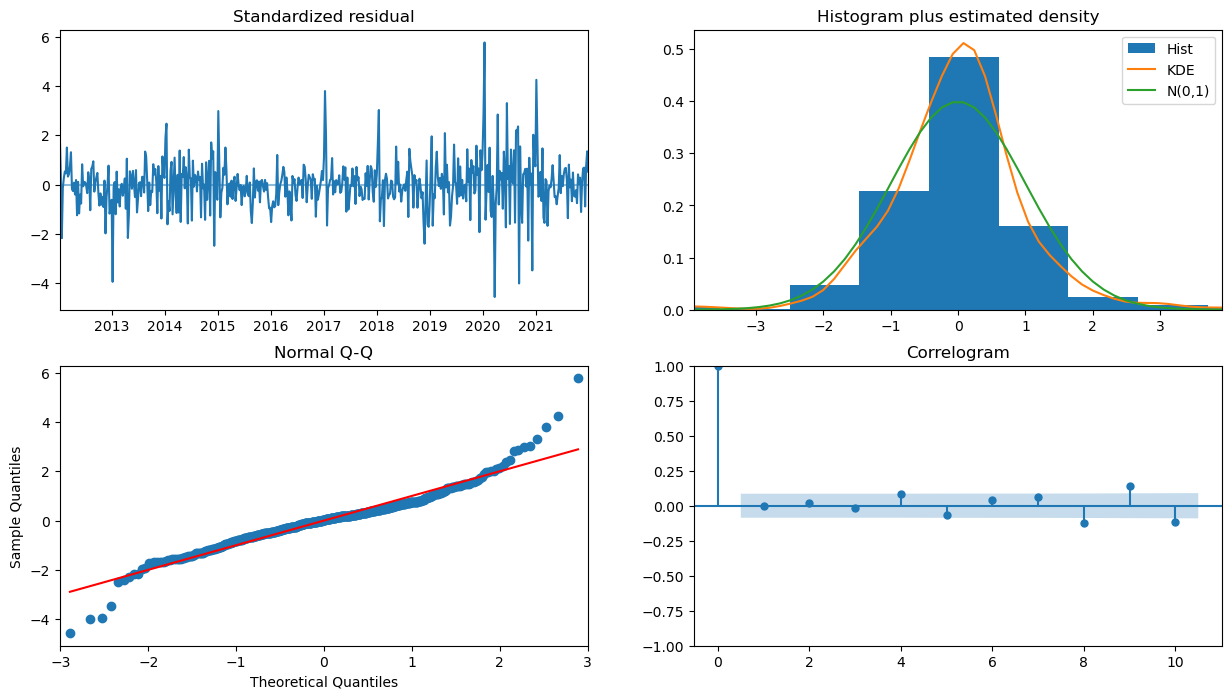

In [304]:
model_autoARIMA = auto_arima(aapl_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [305]:
aapl_model = ARIMA(aapl_train, order=(3,1,2),freq='W-MON')
aapl_fitted = aapl_model.fit()  
print(aapl_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  522
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 601.188
Date:                Mon, 24 Apr 2023   AIC                          -1190.376
Time:                        22:04:38   BIC                          -1164.841
Sample:                    01-02-2012   HQIC                         -1180.374
                         - 12-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5603      0.040    -14.081      0.000      -0.638      -0.482
ar.L2         -0.6761      0.035    -19.337      0.000      -0.745      -0.608
ar.L3         -0.6603      0.026    -25.709      0.0

In [313]:
history = [x for x in aapl_train]
model_predictions = []
N_test_observations = len(aapl_test)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(3,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = aapl_test[time_point]
    history.append(true_test_value)

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [314]:
aapl_MSE_error = mean_squared_error(aapl_test, model_predictions)
print('Testing Mean Squared Error for Apple is {}'.format(aapl_MSE_error))

Testing Mean Squared Error for Apple is 0.0035069548111413182


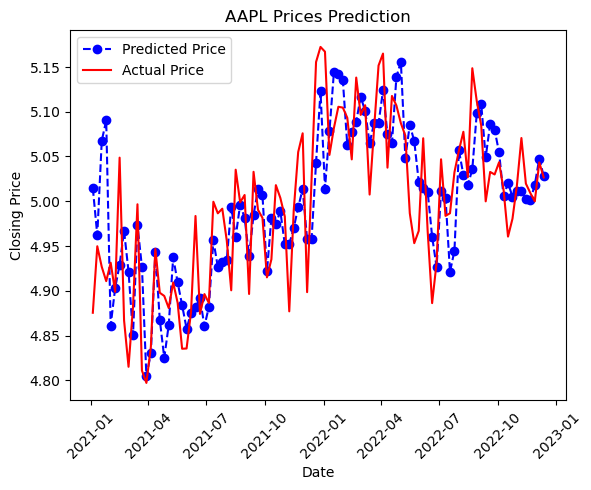

In [315]:
test_set_range= aapl_test.index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, aapl_test, color='red', label='Actual Price')
plt.title('AAPL Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

### ARIMA Model for Microsoft

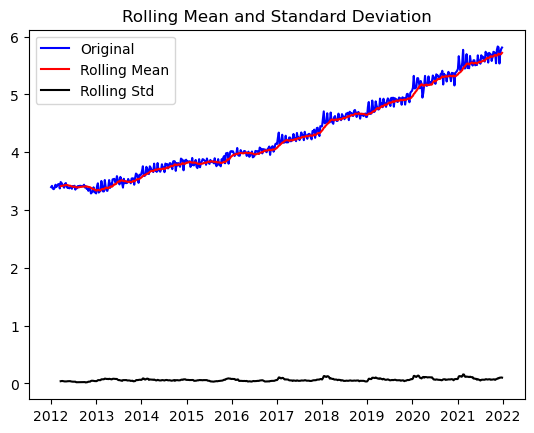

P-value:  0.9987920652970309


In [316]:
stationarity_check(msft_train)
ad_test(msft_train)

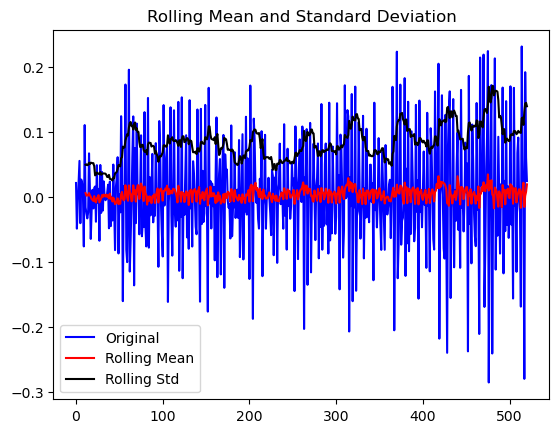

P-value:  5.754193317044616e-12


In [317]:
msft_diff = np.diff(msft_train)
msft_diff = pd.DataFrame(msft_diff)
stationarity_check(msft_diff)
ad_test(msft_diff)

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


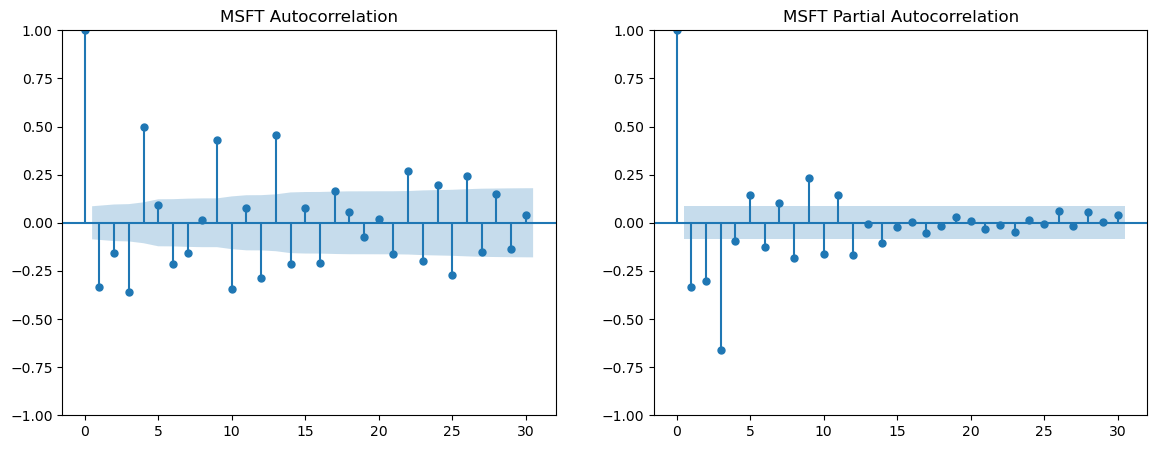

In [318]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
msft_acf = plot_acf(msft_diff, lags=30, ax=ax[0],alpha=.05)
msft_pacf = plot_pacf(msft_diff, lags=30, ax=ax[1],alpha=.05)
ax[0].set_title('MSFT Autocorrelation')
ax[1].set_title('MSFT Partial Autocorrelation')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1080.740, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1140.827, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1292.312, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1081.209, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1295.678, Time=1.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1294.661, Time=0.79 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1314.717, Time=2.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1348.728, Time=3.49 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1392.634, Time=4.21 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1369.954, Time=2.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1493.576, Time=5.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1492.547, Time=2.70 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-1471.872, Time=1.91 sec

Best model:  ARIMA(3,1,3

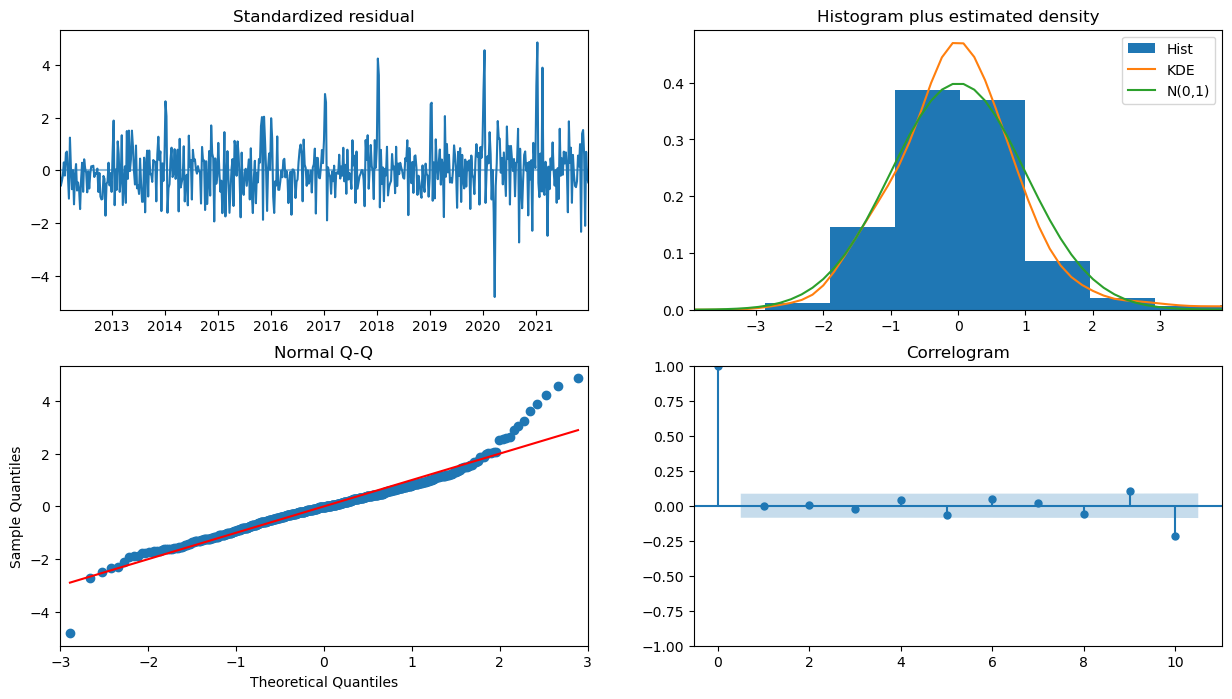

In [319]:
model_autoARIMA = auto_arima(msft_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [320]:
msft_model = ARIMA(msft_train, order=(3,1,3),freq='W-MON')
msft_fitted = msft_model.fit()  
print(msft_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  522
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 742.936
Date:                Mon, 24 Apr 2023   AIC                          -1471.872
Time:                        22:08:59   BIC                          -1442.081
Sample:                    01-02-2012   HQIC                         -1460.203
                         - 12-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5481      0.050    -10.971      0.000      -0.646      -0.450
ar.L2         -0.6782      0.052    -13.158      0.000      -0.779      -0.577
ar.L3         -0.6559      0.046    -14.286      0.0

In [ ]:
history = [x for x in msft_train]
model_predictions = []
N_test_observations = len(msft_test)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(3,1,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = msft_test[time_point]
    history.append(true_test_value)

In [322]:
msft_MSE_error = mean_squared_error(msft_test, model_predictions)
print('Testing Mean Squared Error for Microsoft is {}'.format(msft_MSE_error))

Testing Mean Squared Error for Microsoft is 0.005663002705183942


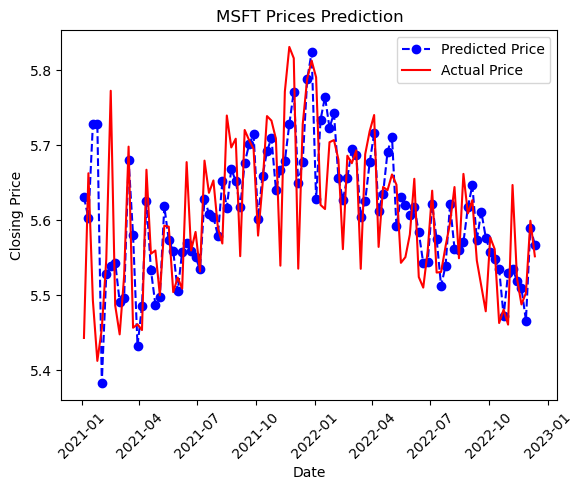

In [323]:
#test_set_range = amzn_week[int(len(amzn_week)*0.7):].index
test_set_range= msft_test.index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, msft_test, color='red', label='Actual Price')
plt.title('MSFT Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

## Conclusion

Our results show that the ARIMA  model was able to forecast the underlying trends and patterns of different stock prices. Overall, this project demonstrates methods to extract data and use time series forcasting  and ARIMA to forcast stock prices of the top 3 NASDAQ comapnies in a way so that it can be repeated for other companies. The model's low MSE score show that the prediction is relatively accurate. Although the models demonstrates good performance of the model there were some limitations as these models. It cannot count real life events into consideration such as plitical events, news events, and COVID19. Hence wouldn't be great to rely soley on these observation as stock prices are known to be very volatile, instead should just be referenced.  

## References

Serafeim Loukas, PhD. “Time-Series Forecasting: Predicting Stock Prices Using an Arima Model.” Medium, Towards Data Science, 21 Apr. 2023, https://towardsdatascience.com/time-series-forecasting-predicting-stock-prices-using-an-arima-model-2e3b3080bd70. 